# **Bitcoin Time Series Momentum Trading**

In [1]:
from datetime import datetime, timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
import talib as ta

from plotly.subplots import make_subplots
from scipy.stats import skew, kurtosis, mstats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

In [2]:
bitcoin_1min = pl.read_csv("btcusd_1-min_data.csv")

bitcoin_1min = bitcoin_1min.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
).rename({"Timestamp": "Date"})

print(bitcoin_1min)

shape: (6_729_281, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬───────────┐
│ Date                ┆ Open     ┆ High     ┆ Low      ┆ Close    ┆ Volume    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ datetime[μs]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╡
│ 2012-01-01 10:01:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:02:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:03:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:04:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ 2012-01-01 10:05:00 ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 4.58     ┆ 0.0       │
│ …                   ┆ …        ┆ …        ┆ …        ┆ …        ┆ …         │
│ 2024-12-15 23:57:00 ┆ 104510.0 ┆ 104510.0 ┆ 104257.0 ┆ 104268.0 ┆ 27.923539 │
│ 2024-12-15 23:58

In [3]:
print(bitcoin_1min.null_count())

shape: (1, 6)
┌──────┬──────┬──────┬─────┬───────┬────────┐
│ Date ┆ Open ┆ High ┆ Low ┆ Close ┆ Volume │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---    │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32   ┆ u32    │
╞══════╪══════╪══════╪═════╪═══════╪════════╡
│ 1    ┆ 0    ┆ 0    ┆ 0   ┆ 0     ┆ 0      │
└──────┴──────┴──────┴─────┴───────┴────────┘


In [4]:
bitcoin_1min = bitcoin_1min.filter(
    pl.col("Date").is_not_null()
)

## **Exploratory Data Analysis**

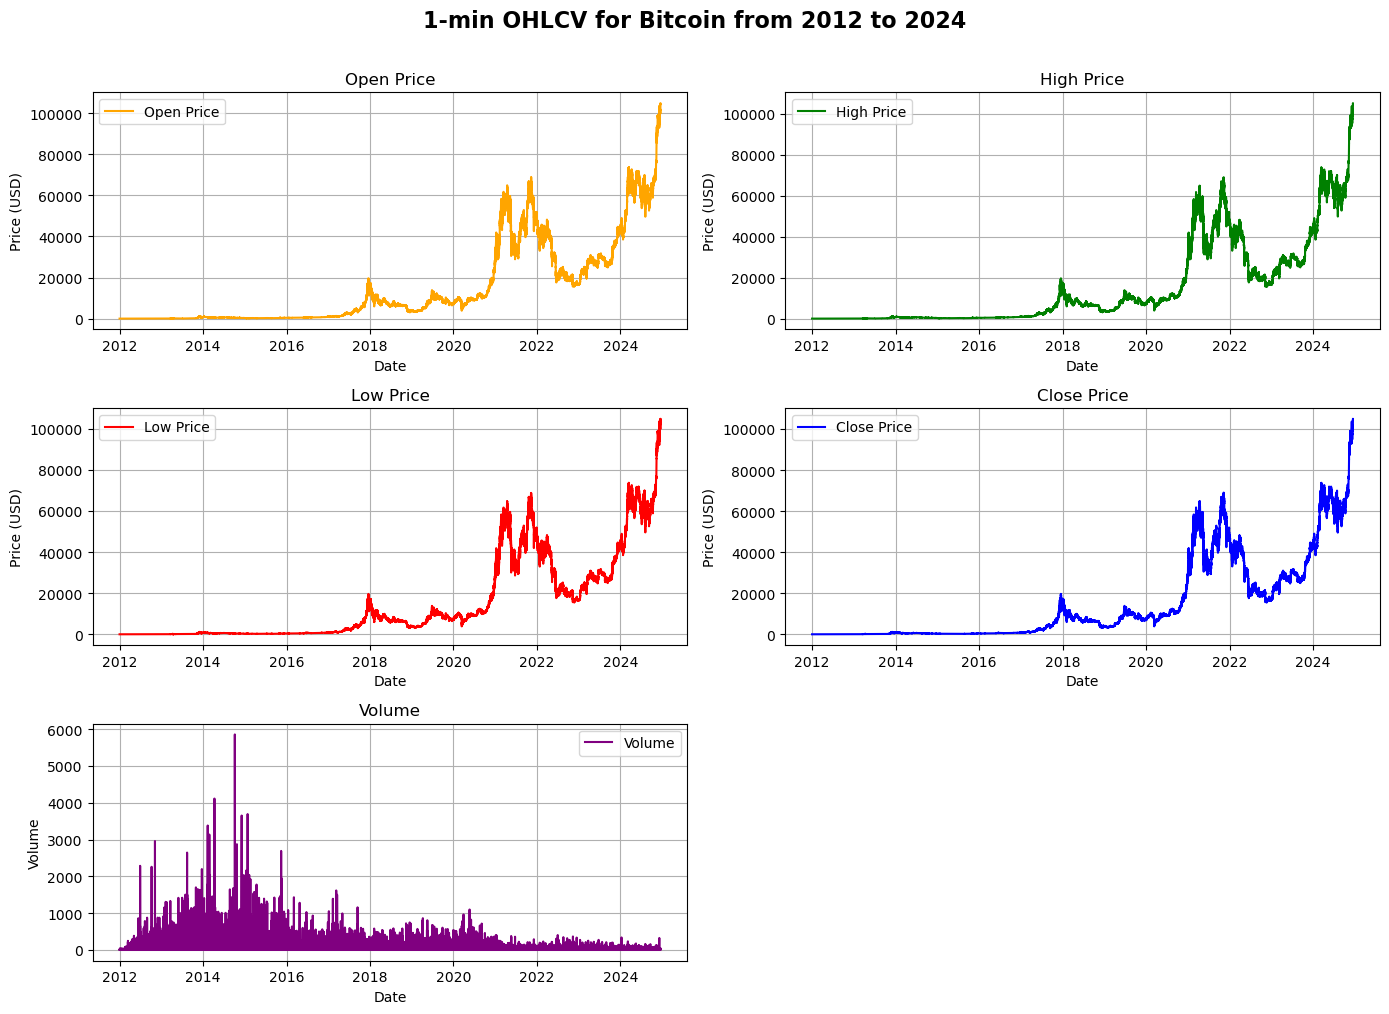

In [6]:
def plot_ohlcv(prices):
    """
    Plots Open, High, Low, Close and Volume prices in a 3x2 grid.

    Args:
        bitcoin (pl.DataFrame): Polars DataFrame containing OHLC and Volume data.
    """
    ohlcv_configs = [
        ("Open", "orange", "Open Price"),
        ("High", "green", "High Price"),
        ("Low", "red", "Low Price"),
        ("Close", "blue", "Close Price"),
        ("Volume", "purple", "Volume")
    ]

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    plt.suptitle("1-min OHLCV for Bitcoin from 2012 to 2024", fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (col_name, color, title) in zip(axes, ohlcv_configs):
        ax.plot(prices["Date"], prices[col_name], color=color, label=title)
        ax.set_title(title)
        ax.set_ylabel(f"Price (USD)" if col_name != "Volume" else "Volume")
        ax.set_xlabel("Date")
        ax.legend()
        ax.grid(True)

    for ax in axes[len(ohlcv_configs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_ohlcv(bitcoin_1min)

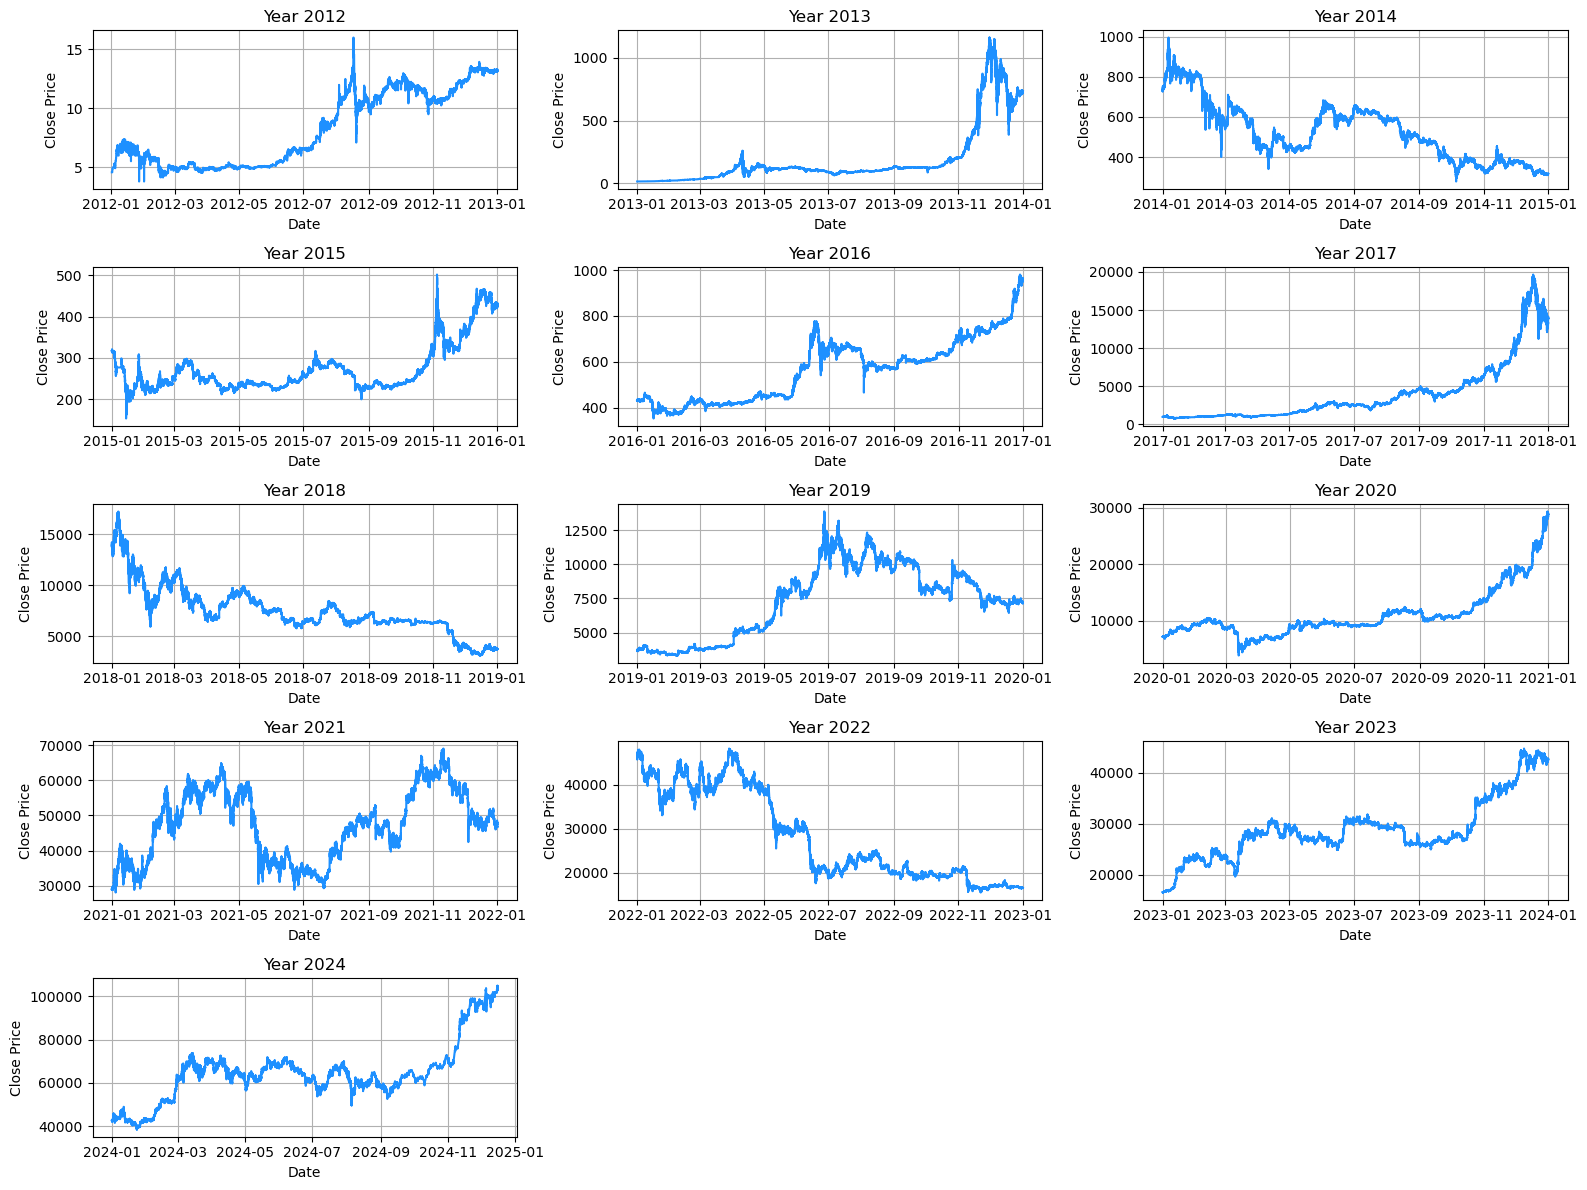

In [9]:
import polars as pl
import matplotlib.pyplot as plt

def plot_yearly_closing(prices):
    """
    Plots a grid of line plots showing Bitcoin closing prices for each year.

    Args:
        prices (pl.DataFrame): Polars DataFrame with 'Date' and 'Close' columns.
    """

    # Extract year from the Date column
    prices = prices.with_columns(pl.col("Date").dt.year().alias("year"))

    # Group by year and aggregate Date and Close columns
    yearly_groups = prices.group_by("year").agg([
        pl.col("Date").alias("dates"),
        pl.col("Close").alias("close_prices")
    ]).sort("year")

    # Plotting parameters
    n_years = len(yearly_groups)
    n_cols = 3  # Number of columns in the grid
    n_rows = (n_years // n_cols) + (n_years % n_cols > 0)  # Dynamically calculate rows

    # Set up subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()

    # Plot each year's data
    for i in range(n_years):
        ax = axes[i]

        # Access each row directly from the DataFrame
        year = yearly_groups["year"][i]
        dates = yearly_groups["dates"][i]
        close_prices = yearly_groups["close_prices"][i]

        ax.plot(dates, close_prices, color='dodgerblue')
        ax.set_title(f"Year {year}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Close Price")
        ax.grid(True)

    # Hide unused subplots (if any)
    for i in range(n_years, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_yearly_closing(bitcoin_1min)

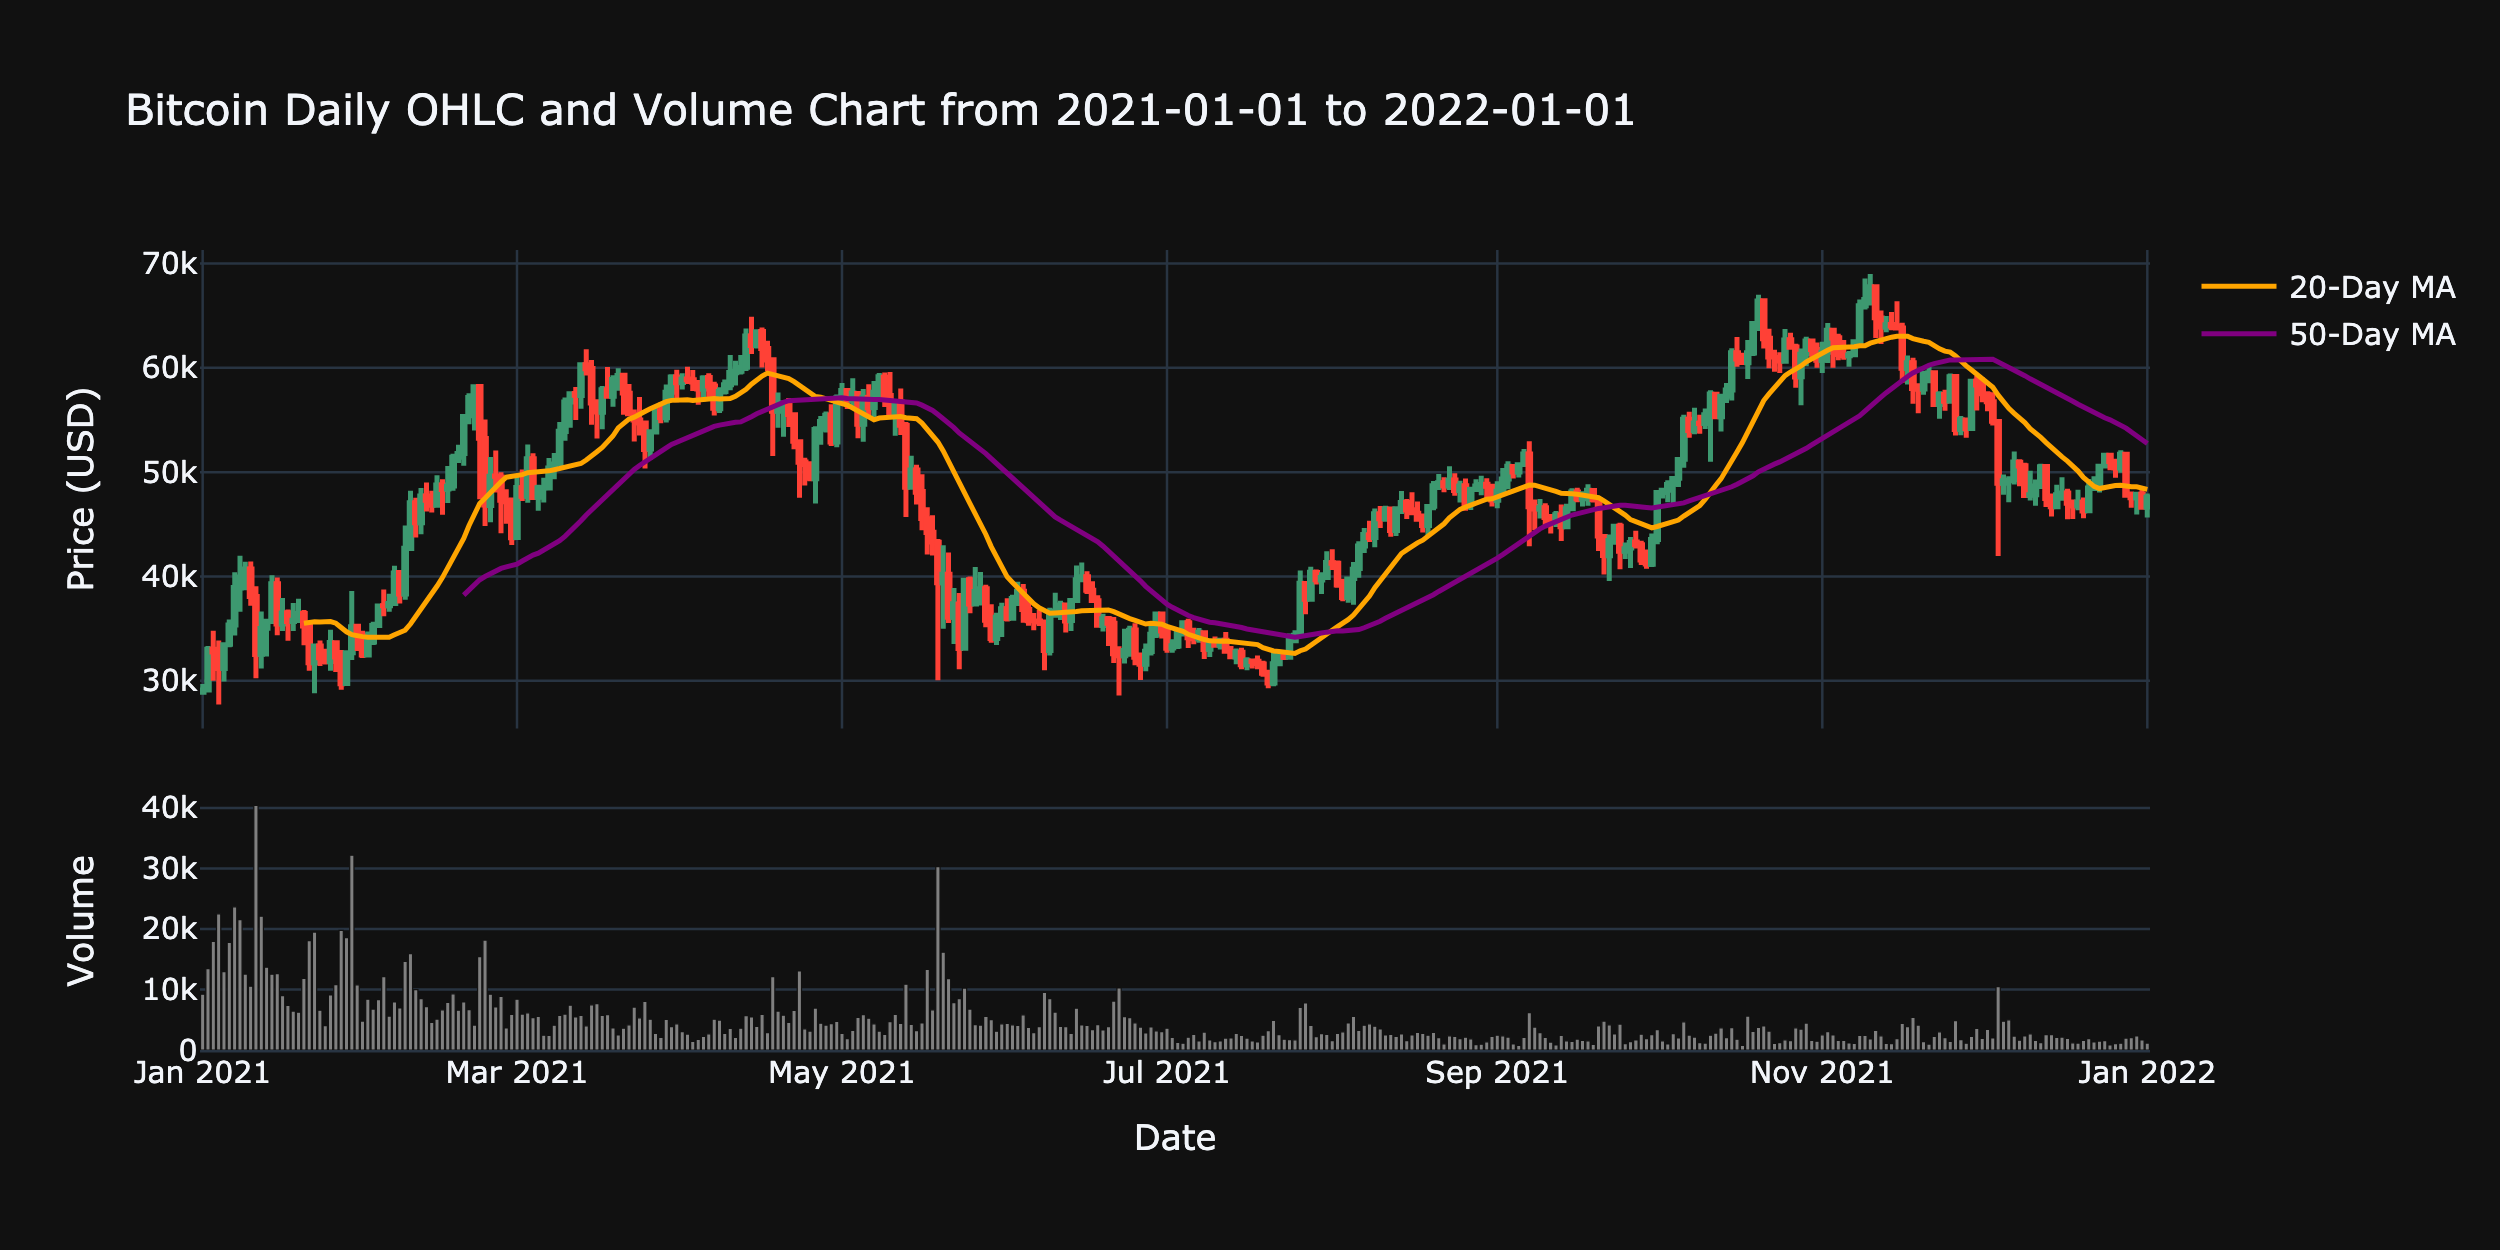

In [21]:
from IPython.display import Image
def plot_daily_candlesticks(prices, start, end=None):
    prices_daily = prices.group_by(
        pl.col("Date").dt.date().alias("Day")
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Day")

    if end:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start,
            pl.col("Day") <= end
        )
    else:
        prices_daily = prices_daily.filter(
            pl.col("Day") >= start
        )

    prices_daily = prices_daily.with_columns(
        pl.col("Close").rolling_mean(window_size=20).alias("MA_20"),
        pl.col("Close").rolling_mean(window_size=50).alias("MA_50")
    )

    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, 
        row_heights=[0.65, 0.35],  
        vertical_spacing=0.08, 
    )

    fig.add_trace(
        go.Candlestick(
            x=prices_daily.select('Day').to_series(),
            open=prices_daily.select('Open').to_series(),
            high=prices_daily.select('High').to_series(),
            low=prices_daily.select('Low').to_series(),
            close=prices_daily.select('Close').to_series(),
            showlegend=False
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('MA_20').to_series(),
            line=dict(color='orange', width=2),
            name="20-Day MA"
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('MA_50').to_series(),
            line=dict(color='purple', width=2),
            name="50-Day MA"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=prices_daily.select('Day').to_series(),
            y=prices_daily.select('Volume').to_series(),
            marker_color="gray",
            showlegend=False
        ),
        row=2, col=1
    )

    min_date = prices_daily["Day"].min()
    max_date = prices_daily["Day"].max()
    fig.update_layout(
        title_text=f"Bitcoin Daily OHLC and Volume Chart from {min_date} to {max_date}",
        yaxis_title="Price (USD)",
        xaxis2_title="Date",
        yaxis2_title="Volume",
        template="plotly_dark",
        width=1000, height=600,
        xaxis_rangeslider_visible=False,
        showlegend=True,
    )
    fig.write_image("plots/candlesticks.png", scale=2.5, width=1000, height=500)

plot_daily_candlesticks(bitcoin_1min, datetime(2021, 1,1), datetime(2022, 1, 1))
Image("plots/candlesticks.png")

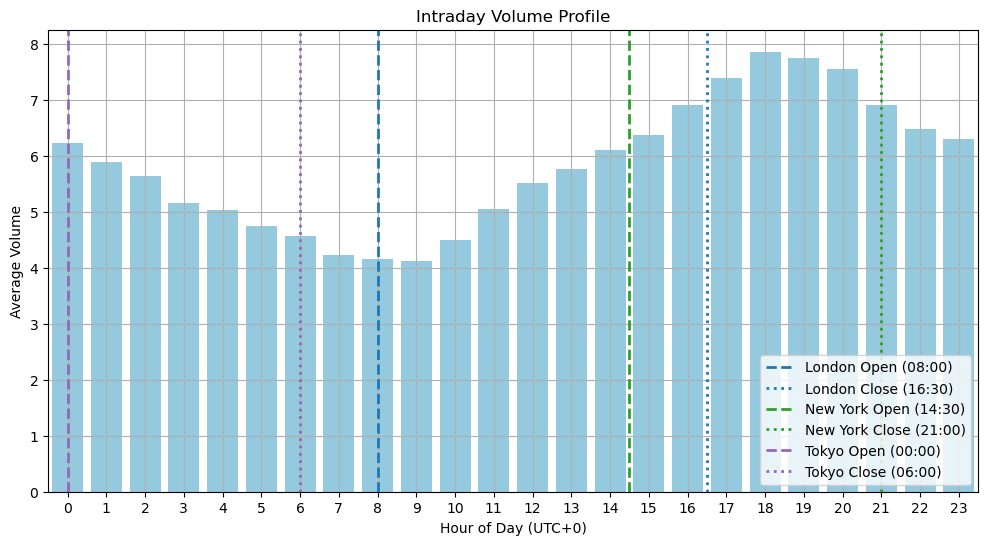

In [22]:
def plot_intraday_volume_profile(prices):
    prices = prices.with_columns(
        prices.select("Date").to_series().dt.hour().alias("hour")
    )

    avg_volume_by_hour = (prices.group_by("hour")
        .agg(pl.col("Volume").mean().alias("Average_Volume"))
        .sort("hour")
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_volume_by_hour["hour"], y=avg_volume_by_hour["Average_Volume"], color="skyblue")

    plt.title("Intraday Volume Profile")
    plt.xlabel("Hour of Day (UTC+0)")

    plt.axvline(x=8, color='#1f77b4', linestyle='--', linewidth=2, label="London Open (08:00)")
    plt.axvline(x=16.5, color='#1f77b4', linestyle=':', linewidth=2, label="London Close (16:30)")

    plt.axvline(x=14.5, color='#2ca02c', linestyle='--', linewidth=2, label="New York Open (14:30)")
    plt.axvline(x=21, color='#2ca02c', linestyle=':', linewidth=2, label="New York Close (21:00)")

    plt.axvline(x=0, color='#9467bd', linestyle='--', linewidth=2, label="Tokyo Open (00:00)")
    plt.axvline(x=6, color='#9467bd', linestyle=':', linewidth=2, label="Tokyo Close (06:00)")

    plt.ylabel("Average Volume")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_intraday_volume_profile(bitcoin_1min)

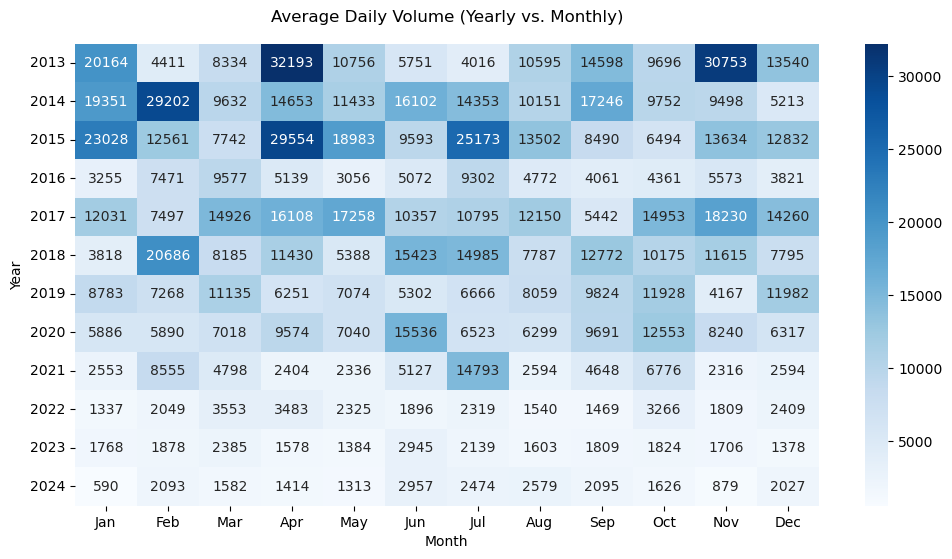

In [23]:
def plot_calendar_map(prices):
    prices = prices.with_columns([
        pl.col("Date").dt.year().alias('year'),
        pl.col("Date").dt.month().alias('month'),
        pl.col("Date").dt.date().alias('day')
    ])

    # aggregate to daily volume
    daily_volume = prices.group_by(['year', 'month', 'day']).agg(
        pl.sum("Volume").alias("daily_volume")
    )

    # calculate average daily volume per month for each year
    avg_monthly_volume = daily_volume.group_by(['year', 'month']).agg(
        pl.mean("daily_volume").alias("avg_daily_volume")
    )

    heatmap_data = avg_monthly_volume.pivot(
        on='month', 
        index='year', 
        values='avg_daily_volume'
    ).sort(by="year").to_pandas()

    heatmap_data = heatmap_data.set_index('year')
    heatmap_data.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".0f")
    plt.title('Average Daily Volume (Yearly vs. Monthly)', y=1.03)
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.yticks(rotation=0)
    plt.show()

plot_calendar_map(bitcoin_1min)

### **Resampling**

In [6]:
def resample_ohlcv(prices, freq):
    """
    Resample OHLCV data to a specified frequency.

    Args:
        prices (pl.DataFrame): The Polars DataFrame containing OHLCV data.
        freq (str): The resampling frequency (e.g., '5m', '10m', '15m').

    Returns:
        pl.DataFrame: Resampled OHLCV DataFrame.
    """
    return prices.group_by(
        pl.col("Date").dt.truncate(freq)
    ).agg([
        pl.col("Open").first().alias("Open"),
        pl.col("High").max().alias("High"),
        pl.col("Low").min().alias("Low"),
        pl.col("Close").last().alias("Close"),
        pl.col("Volume").sum().alias("Volume")
    ]).sort("Date")

freqs = ["5m", "10m", "15m"]
resampled_bitcoin = {"bitcoin_1m": bitcoin_1min}

for freq in freqs:
    resampled_bitcoin[f"bitcoin_{freq}"] = resample_ohlcv(bitcoin_1min, freq)

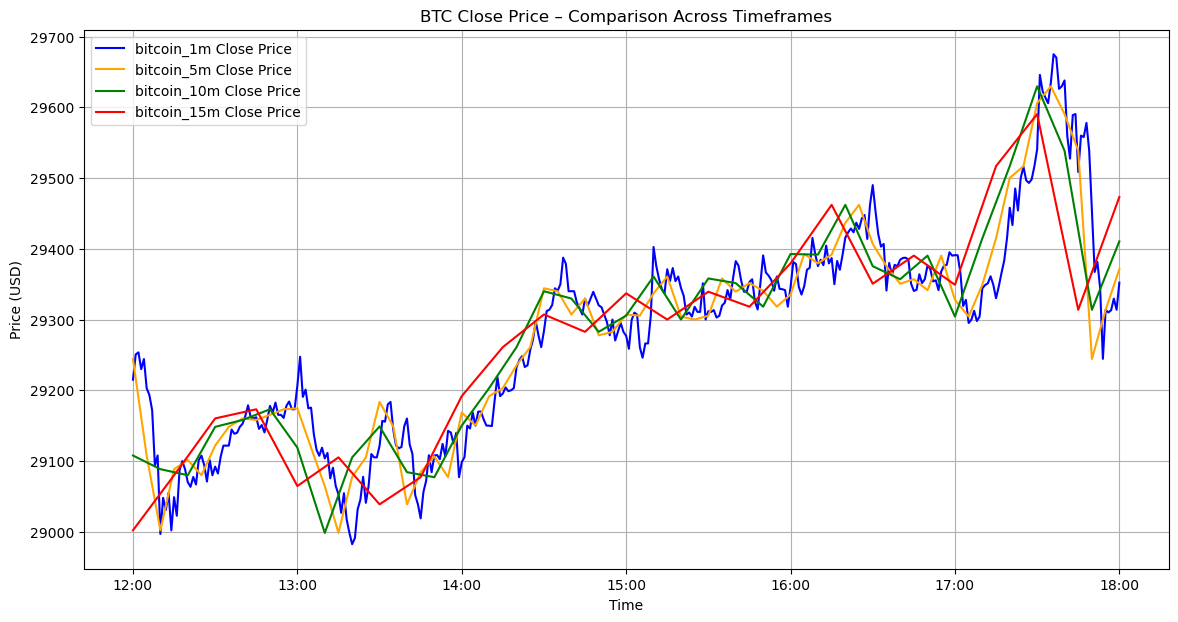

In [7]:
COLOR_MAP = {
    "bitcoin_1m": "blue",
    "bitcoin_5m": "orange",
    "bitcoin_10m": "green",
    "bitcoin_15m": "red"
}

def plot_resampled(resampled_data, start, end):
    """
    Plot BTC price data across multiple timeframes to visualize smoothing trends.
    
    Args:
        resampled_data (dict): Dictionary of resampled Polars DataFrames (5min, 10min, etc.).
        start (datetime): Start datetime for the plot.
        end (datetime): End datetime for the plot.
    """
    plt.figure(figsize=(14, 7))

    for freq, df in resampled_data.items():
        subset = df.filter(
            (pl.col("Date") >= start) & (pl.col("Date") <= end)
        ).select("Date", "Close")
        
        plt.plot(
            subset.select("Date"), subset.select("Close"), 
            color=COLOR_MAP.get(freq, "blue"),
            label=f"{freq} Close Price",
        )

    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.title("BTC Close Price – Comparison Across Timeframes")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

start = datetime(2021, 1, 1, 12)
end = start + timedelta(hours=6)
plot_resampled(resampled_bitcoin, start=start, end=end)

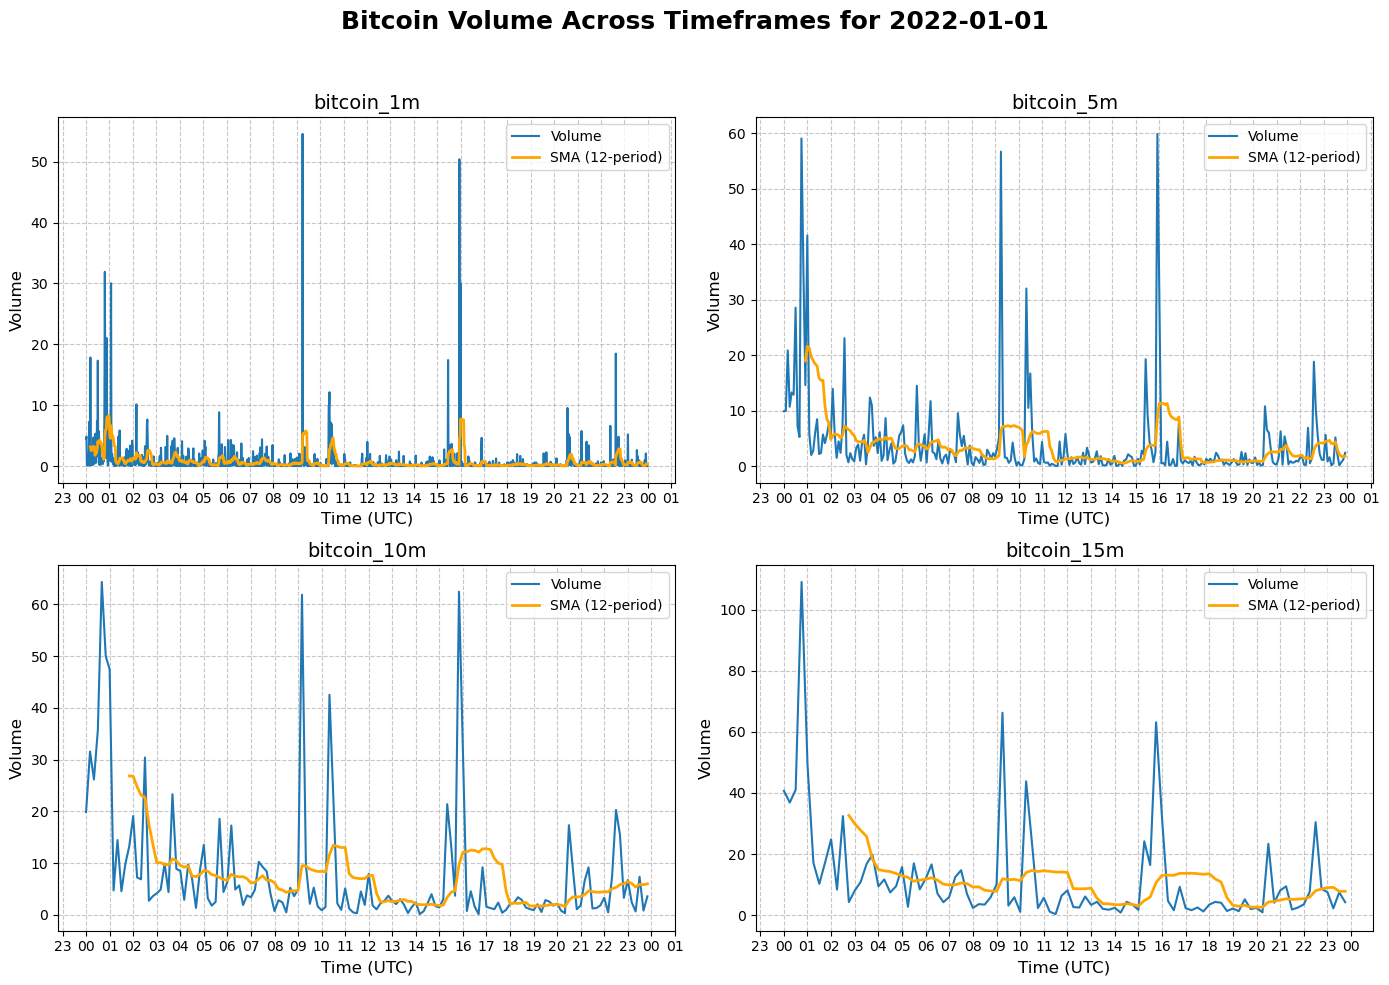

In [26]:
def plot_volume_day_resampled(resampled_data, day, window_sizes=None):
    """
    Plot Bitcoin volume and SMAs for a specific day across different resampled dataframes.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with resampled OHLCV data.
        day (datetime): Date to filter and plot.
        window_sizes (dict): Custom window sizes for each resampling period.
    """
    window_sizes = {} if window_sizes is None else window_sizes
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for ax, (freq, df) in zip(axes, resampled_data.items()):
        window_size = window_sizes.get(freq, 12)  # Default to 12 if not specified

        filtered_prices = df.filter(
            pl.col("Date").dt.date() == day.date()
        ).with_columns(
            pl.col("Volume").rolling_mean(window_size=window_size).alias("SMA_1h")
        ).select("Date", "Volume", "SMA_1h").to_pandas()

        # Plot volume and SMA
        ax.plot(filtered_prices["Date"], filtered_prices["Volume"], linewidth=1.5, label='Volume')
        ax.plot(filtered_prices["Date"], filtered_prices["SMA_1h"], color='orange', linewidth=2, label=f"SMA ({window_size}-period)")

        ax.set_title(f"{freq}", fontsize=14)
        ax.set_xlabel("Time (UTC)", fontsize=12)
        ax.set_ylabel("Volume", fontsize=12)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc="upper right")

    plt.suptitle(f"Bitcoin Volume Across Timeframes for {day.strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

window_sizes = {
    "bitcoin_1m": 60,   # 1-hour SMA (60 x 1m = 60m)
    "bitcoin_5m": 12,   # 1-hour SMA (12 x 5m = 60m)
    "bitcoin_10m": 6,   # 1-hour SMA (6 x 10m = 60m)
    "bitcoin_15m": 4,   # 1-hour SMA (4 x 15m = 60m)
}
day = datetime(2022, 1, 1)
plot_volume_day_resampled(resampled_bitcoin, day)

Intraday volume displays frequent spikes which may not be deseribale from a modelling perspective.

### **Log Returns**

In [27]:
def calculate_log_returns(prices, col_name="Close"):
    """
    Calculate log returns for a given price column in a Polars DataFrame.

    Args:
        prices (pl.DataFrame): Polars DataFrame containing OHLC data.
        col_name (str): The column to compute log returns from (default is 'Close').

    Returns:
        pl.DataFrame: DataFrame with an additional 'log_returns' column.
    """
    return prices.with_columns(
        (pl.col(col_name) / pl.col(col_name).shift(1)).log().alias("log_returns")
    ).filter(
        pl.col("log_returns").is_not_null()
    )

# Compute log returns
for freq, df in resampled_bitcoin.items():
    resampled_bitcoin[freq] = calculate_log_returns(df)

# Compute descriptive statistics of log returns
desc_stats = []
statistic_column = None

for freq, df in resampled_bitcoin.items():
    desc = df.select("log_returns").describe()
    
    if statistic_column is None:
        statistic_column = desc.select("statistic")
    desc = desc.select("log_returns").rename({"log_returns": f"{freq} Log Returns"})
    desc_stats.append(desc)

combined_desc = pl.concat([statistic_column] + desc_stats, how="horizontal")
print(combined_desc)

shape: (9, 5)
┌────────────┬────────────────┬────────────────┬─────────────────────────┬─────────────────────────┐
│ statistic  ┆ bitcoin_1m Log ┆ bitcoin_5m Log ┆ bitcoin_10m Log Returns ┆ bitcoin_15m Log Returns │
│ ---        ┆ Returns        ┆ Returns        ┆ ---                     ┆ ---                     │
│ str        ┆ ---            ┆ ---            ┆ f64                     ┆ f64                     │
│            ┆ f64            ┆ f64            ┆                         ┆                         │
╞════════════╪════════════════╪════════════════╪═════════════════════════╪═════════════════════════╡
│ count      ┆ 6.2029e6       ┆ 1.240626e6     ┆ 620336.0                ┆ 413587.0                │
│ null_count ┆ 0.0            ┆ 0.0            ┆ 0.0                     ┆ 0.0                     │
│ mean       ┆ 0.000001       ┆ 0.000007       ┆ 0.000014                ┆ 0.000022                │
│ std        ┆ 0.001786       ┆ 0.003377       ┆ 0.00455                 ┆ 0.

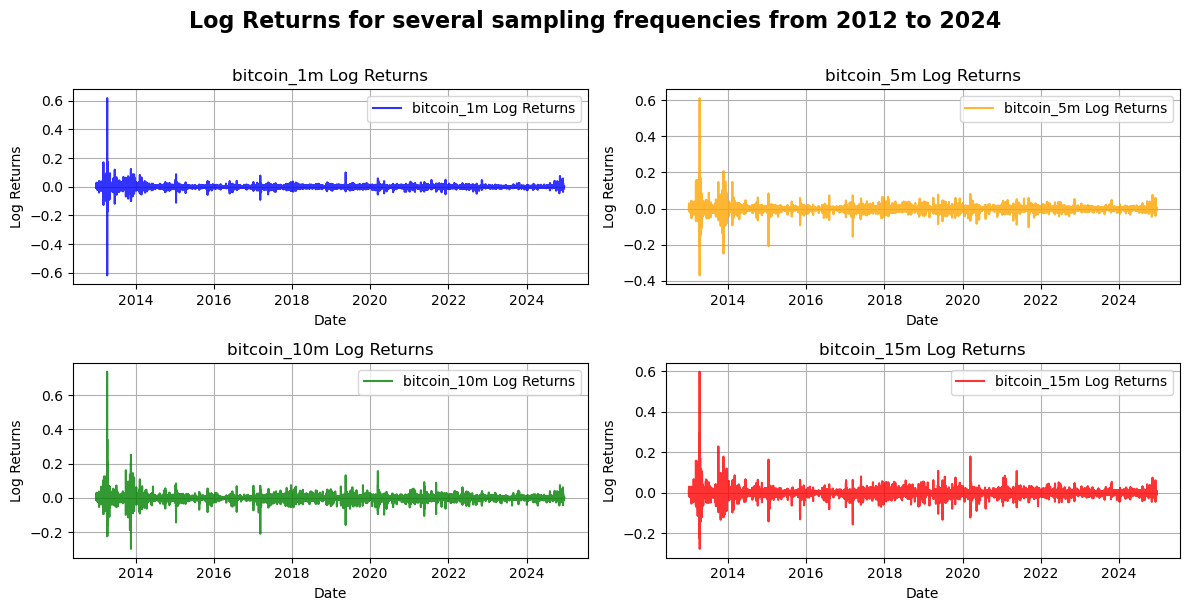

In [48]:
def plot_log_returns_resampled(resampled_data, start=None, end=None):
    """
    Plot log returns as line plots for different timeframes in a 2x2 grid.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        start (datetime, optional): Start date for filtering the data.
        end (datetime, optional): End date for filtering the data.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    plt.suptitle("Log Returns for several sampling frequencies from 2012 to 2024", 
                 fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        # Filter data if start and end are provided
        if start is not None:
            data = data.filter(pl.col("Date") >= start)
        if end is not None:
            data = data.filter(pl.col("Date") <= end)
        
        ax.plot(
            data.select("Date"), data.select("log_returns"), 
            label=f"{freq} Log Returns", color=COLOR_MAP.get(freq, "blue"), alpha=0.8
        )
        
        ax.set_title(f"{freq} Log Returns")
        ax.set_xlabel("Date")
        ax.set_ylabel("Log Returns")
        ax.legend()
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plot_log_returns_resampled(resampled_bitcoin)

As you can see **1-min log rteurns** show little variation while other lower frequencies show much more volatility whihc might indictae a poential more relevence for momentum trading as in momnetum trading we are lookign for stronger movements.

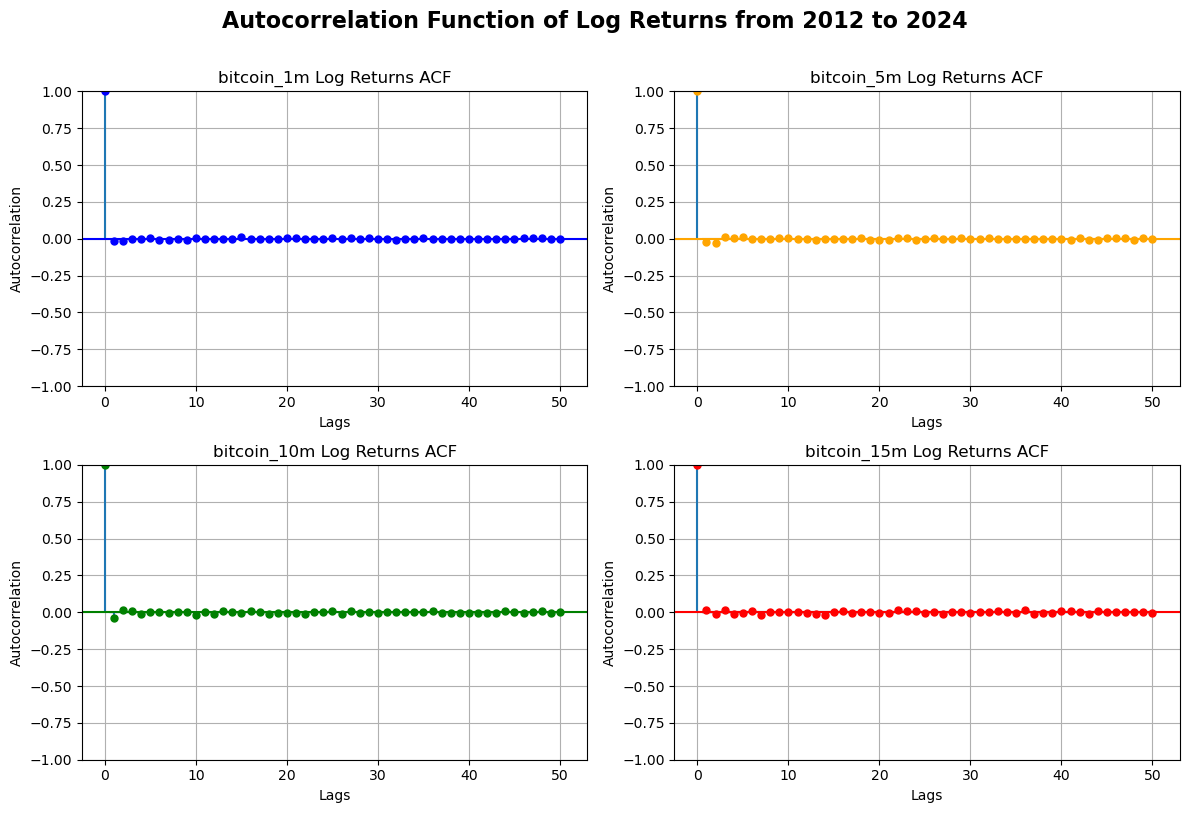

In [49]:
def plot_acf_resampled(resampled_data, start=None, end=None, lags=50):
    """
    Plot ACF (Autocorrelation) for log returns of different resampled DataFrames.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        start (datetime, optional): Start date for filtering the data.
        end (datetime, optional): End date for filtering the data.
        lags (int): Number of lags to display in the ACF plot.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    plt.suptitle("Autocorrelation Function of Log Returns from 2012 to 2024", fontsize=16, fontweight="bold", y=1.01)
    axes = axes.flatten()

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        # Filter data if start and end are provided
        if start is not None:
            data = data.filter(pl.col("Date") >= start)
        if end is not None:
            data = data.filter(pl.col("Date") <= end)
        
        plot_acf(
            data.select("log_returns"), lags=lags, ax=ax, 
            title=f"{freq} Log Returns ACF", 
            color=COLOR_MAP.get(freq, "gray")
        )
        
        ax.grid(True)
        ax.set_xlabel("Lags")
        ax.set_ylabel("Autocorrelation")

    fig.tight_layout()
    plt.show()

start = datetime(2022, 1, 1)
end = datetime(2023, 1, 1)
plot_acf_resampled(resampled_bitcoin, start=start, end=end)

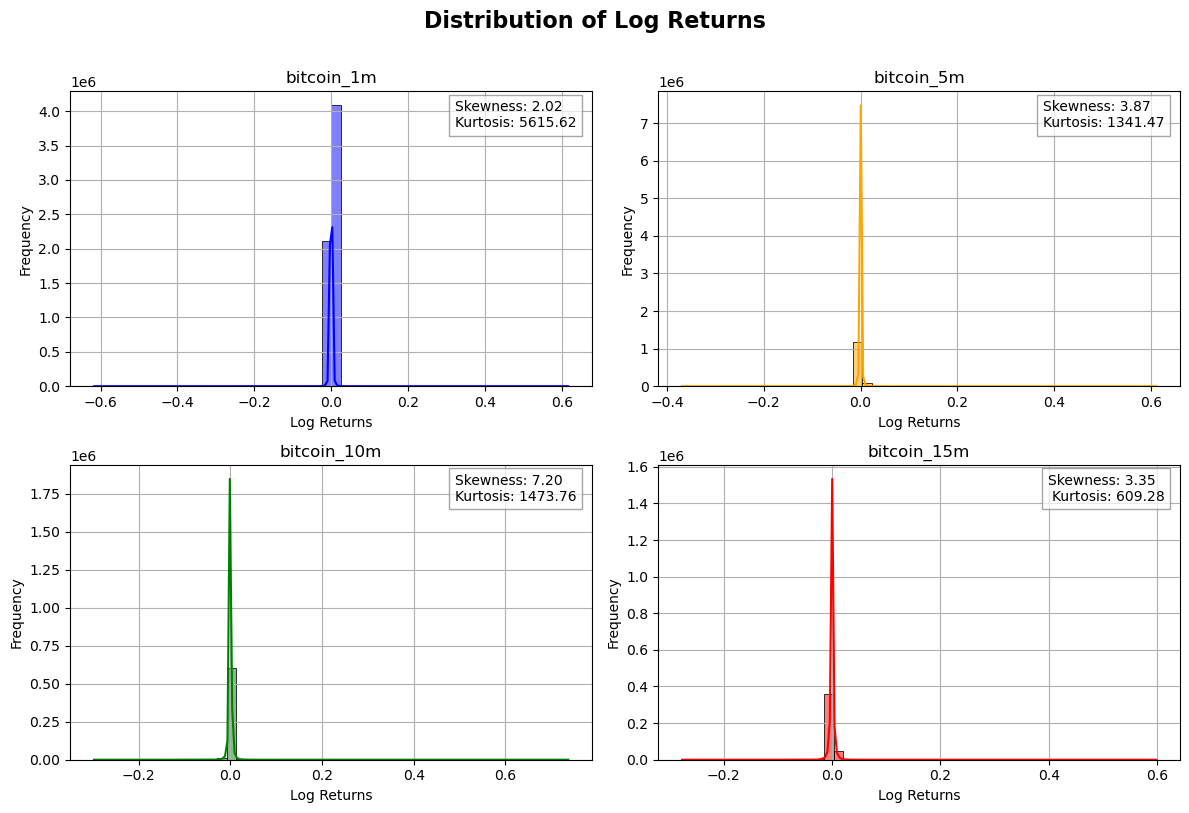

In [52]:
def plot_histograms(resampled_data, col_name, bins=50, stats=False):
    """
    Plot 2x2 grid of histograms for log returns of different resampled DataFrames,
    with skewness and kurtosis displayed in the top-right corner.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
        bins (int): Number of bins for histograms.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    col_name_str = " ".join([name.capitalize() for name in col_name.split("_")])
    plt.suptitle(f"Distribution of {col_name_str}", fontsize=16, fontweight="bold", y=1.01)

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        sns.histplot(
            data[col_name], kde=True, bins=bins, 
            color=COLOR_MAP.get(freq, "gray"), ax=ax
        )
        
        ax.set_title(f"{freq}")
        ax.set_xlabel(f"{col_name_str}")
        ax.set_ylabel("Frequency")
        ax.grid(True)
        
        if stats:
            skewness = skew(data.select(col_name).to_series())
            kurt = kurtosis(data.select(col_name).to_series())
            
            skew_str = f"Skewness: {skewness:.2f}"
            kurt_str = f"Kurtosis: {kurt:.2f}"

            max_length = max(len(skew_str), len(kurt_str))
            skew_str = skew_str.ljust(max_length)
            kurt_str = kurt_str.ljust(max_length)
            textstr = f"{skew_str}\n{kurt_str}"

            ax.text(0.97, 0.97, textstr, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

    
    fig.tight_layout()
    plt.show()

plot_histograms(resampled_bitcoin, "log_returns", stats=True)

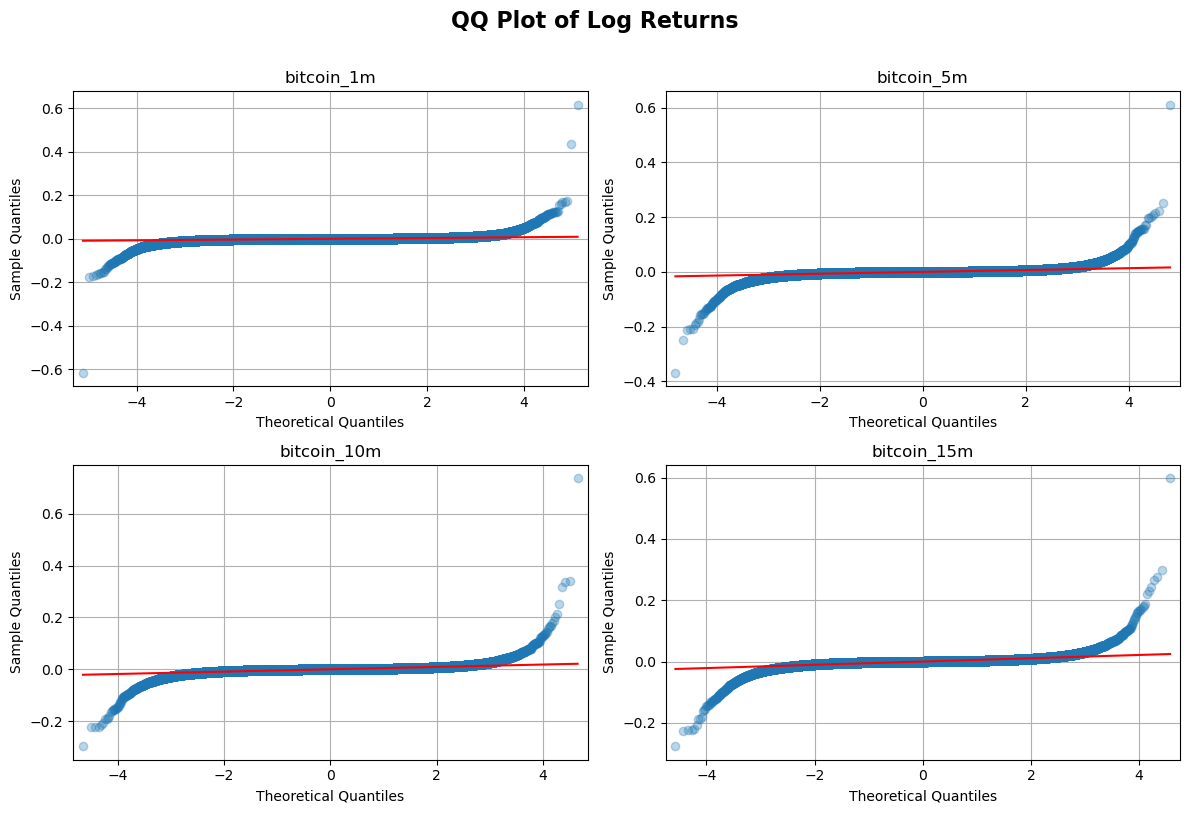

In [53]:
def plot_qq_plots_resampled(resampled_data, col_name):
    """
    Plot a 2x2 grid of QQ plots for log returns of different resampled DataFrames.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames with log returns.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    col_name_str = " ".join([name.capitalize() for name in col_name.split("_")])
    plt.suptitle(f"QQ Plot of {col_name_str}", fontsize=16, fontweight="bold", y=1.01)

    for ax, (interval, df) in zip(axes, resampled_data.items()):
        qqplot(df.select(col_name).to_series(), line="s", ax=ax, alpha=0.3)
        ax.set_title(f"{interval}")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Sample Quantiles")
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plot_qq_plots_resampled(resampled_bitcoin, "log_returns")

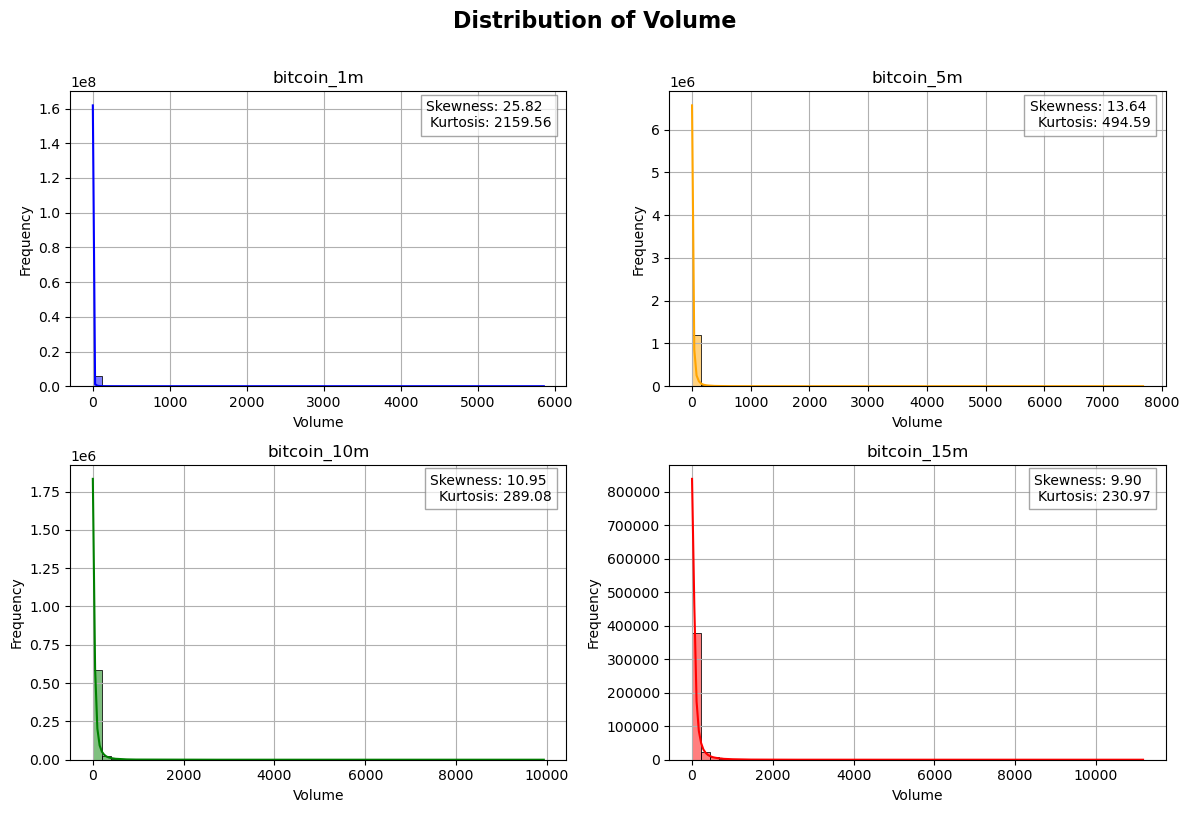

In [54]:
plot_histograms(resampled_bitcoin, "Volume", stats=True)

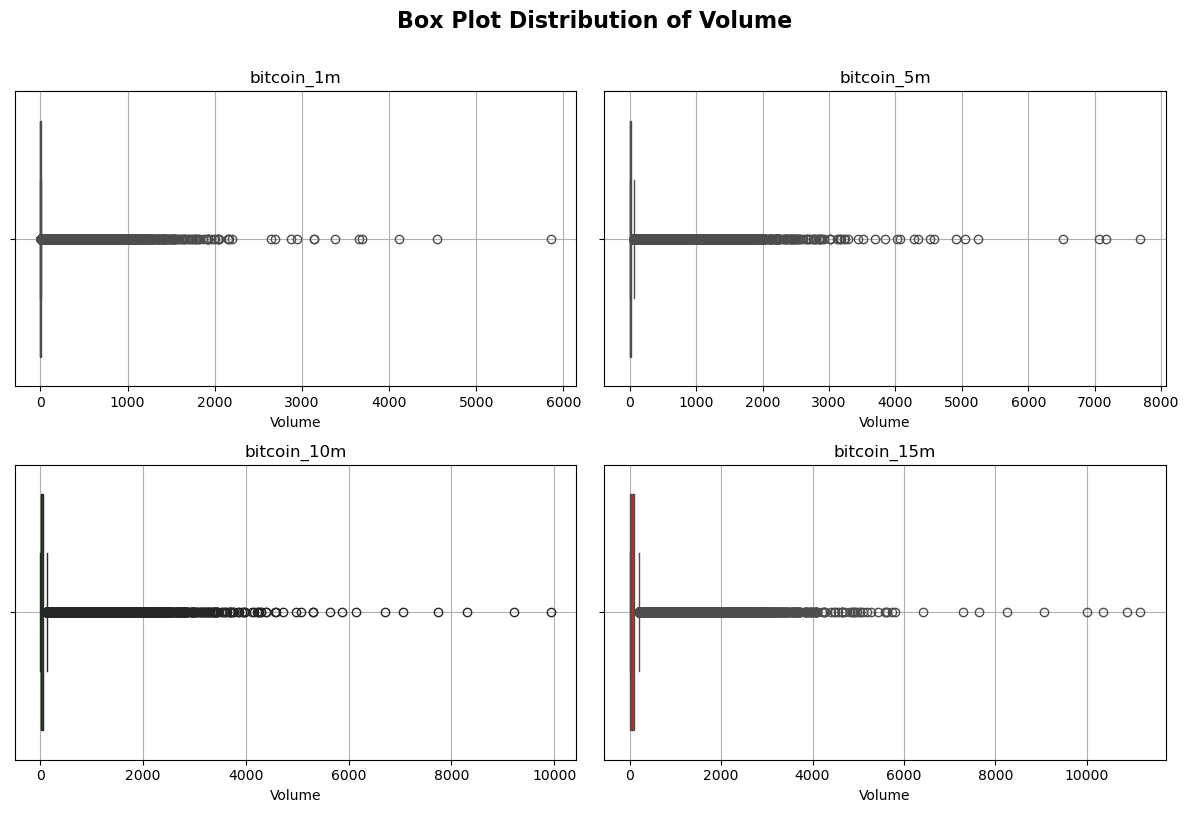

In [55]:
def plot_boxplots(resampled_data, col_name):
    """
    Plot 2x2 grid of box plots for volume or log returns of different resampled DataFrames,
    with skewness and kurtosis displayed in the top-right corner.

    Args:
        resampled_data (dict): Dictionary of Polars DataFrames.
        col_name (str): Name of the column to plot (e.g., "Volume", "log_returns").
        stats (bool): Whether to display skewness and kurtosis on the plots.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    col_name_str = " ".join([name.capitalize() for name in col_name.split("_")])
    plt.suptitle(f"Box Plot Distribution of {col_name_str}", fontsize=16, fontweight="bold", y=1.01)

    for ax, (freq, data) in zip(axes, resampled_data.items()):
        sns.boxplot(x=data[col_name], ax=ax, color=COLOR_MAP.get(freq, "skyblue"))
        ax.set_title(f"{freq}")
        ax.set_xlabel(f"{col_name_str}")
        ax.grid(True)
        

    fig.tight_layout()
    plt.show()

plot_boxplots(resampled_bitcoin, "Volume")

### **Conclusion: The choice of Sampling Frequency**

To strike a balance between data quality and quantity for training deep learning models, we will use **5-minute Bitcoin observations**. This resampling reduces the noise present in 1-minute data while preserving sufficient detail. As a result, we retain approximately **1.4 million observations** which is a reasonbale size for considering deep learning models. Thus in the next sections we will only consider the 5-minutes frequency.

In [8]:
bitcoin = resampled_bitcoin["bitcoin_5m"]

## **Data Pre-processing**

### **Data Cleaning: Handling Outliers**

All frequencies are impacted outliers outisde the interval **[-20%,20%]**, thus a first natural apporahc for addressign extreme observations is to remove them and see if the skweness and kurtosis have been considerably reduced.

In [ ]:
# Define return thresholds based on visual analysis of QQ plot
lower_bound = -0.2  
upper_bound = 0.2

for freq, data in resampled_bitcoin.items():
    resampled_bitcoin[freq] = data.filter(
        (pl.col("log_returns") >= lower_bound) & (pl.col("log_returns") <= upper_bound)
    )

plot_log_return_histograms(resampled_bitcoin, suptitle="Distribution of clean Log Returns 2012 to 2024")

By just eliminating the most extreme outliers we obtain much better distribution shapes with skewness and kurtosis that have considerably been reduced. However, kurtosis is still too high to be considered for modelling perspectives this is why we need a much more advanced outlier handling technique.

Despite removing extreme returns the distribution is still widely spread out, so it may be necessary to address the remaining outlier with a more powerful outlier handling technique. For that we are goign to use a **winsorization**.

In [12]:
def winsorize(df, col_name, thresholds):
    """
    Winsorizes a column in a Polars DataFrame for multiple thresholds.

    Args:
        df (pl.DataFrame): The Polars DataFrame containing the column to winsorize.
        col_name (str): The name of the column to winsorize.
        thresholds (list of tuples): List of (lower_percentile, upper_percentile) tuples.

    Returns:
        pl.DataFrame: A new DataFrame with additional winsorized columns.
    """
    for lower_percentile, upper_percentile in thresholds:
        lower_bound = df.select(pl.col(col_name).quantile(lower_percentile))[0, 0]
        upper_bound = df.select(pl.col(col_name).quantile(upper_percentile))[0, 0]
        
        df = df.with_columns(
            pl.col(col_name).clip(lower_bound, upper_bound).alias(
                f"{col_name}_winsorized_{lower_percentile}_{upper_percentile}"
            )
        )
    return df

thresholds = [(0.10, 0.90), (0.05, 0.95), (0.01, 0.99), (0.005, 0.995)]
log_returns_winsorized = winsorize(bitcoin, "log_returns", thresholds)

In [ ]:
winsorized_columns = [col for col in log_returns_winsorized.columns if "winsorized" in col]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(winsorized_columns):
    sns.histplot(
        log_returns_winsorized.filter(pl.col("Date").dt.date() >= datetime(2016, 1, 1)).select(column).to_series(),
        kde=True, bins=50, ax=axes[i], color="blue"
    )
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Log Returns")
    axes[i].set_ylabel("Frequency")

fig.tight_layout()
plt.show()

The presence of 0 returns create a peaked aorund 0 distribution in all cases, howeevr the **5%-95%** winsorization appears to be the most approrpaiet in this situation.

In [ ]:
log_returns_dec_2024 = bitcoin.filter(
    pl.col("Date") >= datetime(2024, 12, 1)
).select("log_returns")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(log_returns_dec_2024, lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation of 1-min Log Returns for Dec 2024")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

plot_acf(log_returns_daily.select("log_returns"), lags=30, ax=axes[1])
axes[1].set_title("Autocorrelation of Daily Log Returns")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")

plt.show()

In [ ]:
bitcoin = bitcoin.with_columns(
    (pl.col("Close") / pl.col("Close").shift(60)).log().alias("hourly_log_returns")
).filter(
    pl.col("hourly_log_returns").is_not_null()
)
red = bitcoin.filter(
    (pl.col("Date") >= datetime(2024, 1, 1)) & 
    (pl.col("Date") <= datetime(2024, 1, 3)))

plot_acf(red.select("hourly_log_returns"), lags=30);

## **Target Variable**

Because of the complexity of return predictions due to the low noise-to-signal ratio, we are goign to predict the direction of the momentum for the next periods. For that, we can derive many useful fetaures from the OHLCV data which with the obejcitve that they will have predictive power to predict the direction of the momentum.

In [7]:
def create_target(prices, window=20):
    momentum = prices.with_columns(
        ((pl.col("Close") / pl.col("Close").shift(window)) - 1).shift(-window).alias("momentum")
    ).with_columns(
        pl.when(pl.col("momentum") > 0)
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("target")
    ).select("Date", "target")

    return momentum

target = create_target(bitcoin)
target

Date,target
datetime[μs],i8
2012-01-01 10:00:00,0
2012-01-01 10:05:00,0
2012-01-01 10:10:00,0
2012-01-01 10:15:00,0
2012-01-01 10:20:00,0
…,…
2024-12-15 23:40:00,0
2024-12-15 23:45:00,0
2024-12-15 23:50:00,0


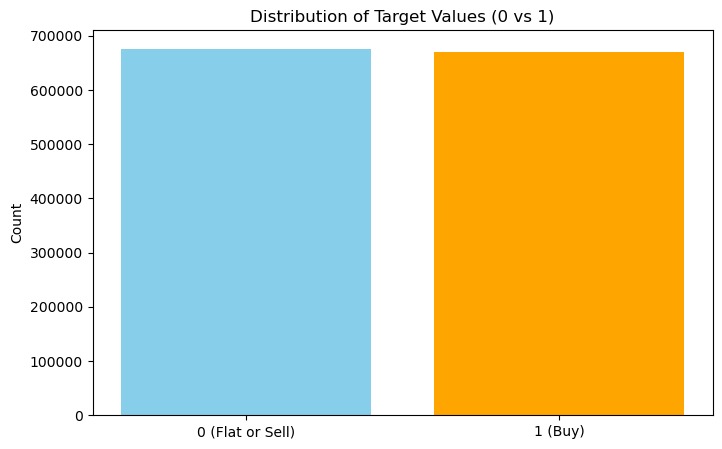

In [8]:
target_counts = target.group_by('target').len().rename({"len": "count"})

plt.figure(figsize=(8, 5))
plt.bar(target_counts['target'], target_counts['count'], color=['skyblue', 'orange'])
plt.xticks([0, 1], ['0 (Flat or Sell)', '1 (Buy)'])
plt.ylabel('Count')
plt.title('Distribution of Target Values (0 vs 1)')
plt.show()

<Axes: xlabel='Date'>

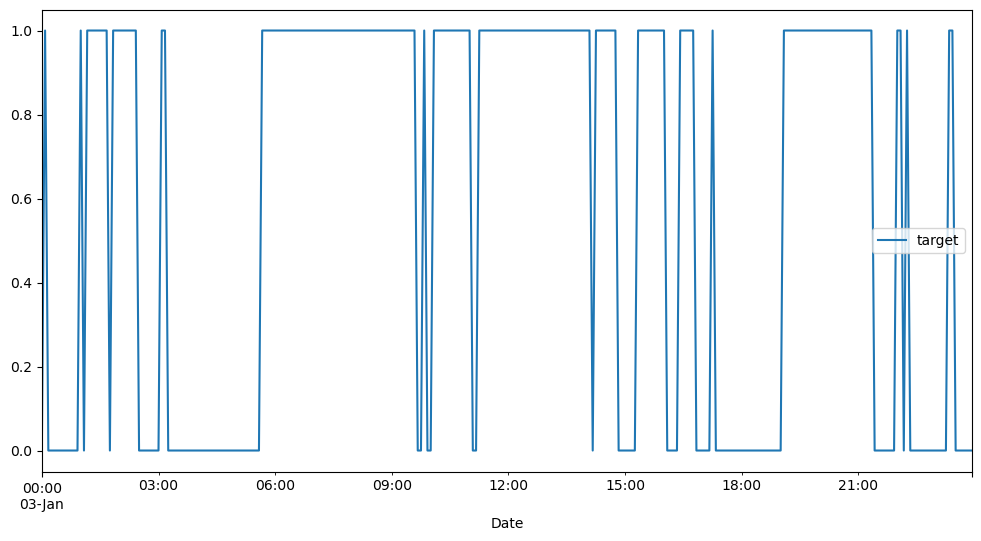

In [9]:
target.to_pandas().set_index("Date").loc["2020-01-03"].plot(figsize=(12, 6))

## **Features**

### **Technical indicators Features**

In [9]:
def create_technical_indicators_features(prices, windows=[7, 14, 20, 30]):
    """
    Extract technical indicators (SMA, EMA, MACD, RSI, ATR, Bollinger Bands) 
    from a Polars DataFrame using TA-Lib.

    Args:
        prices (pl.DataFrame): Polars DataFrame with OHLCV data.
        windows (list): List of window sizes for technical indicators.

    Returns:
        pl.DataFrame: Polars DataFrame with TA-Lib indicators for each window.
    """
    close = prices["Close"]
    high = prices['High']
    low = prices['Low']

    indicator_columns = []

    # Moving Average Convergence Divergence
    macd, macd_signal, _ = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    indicator_columns.extend([
        pl.Series('MACD', macd),
        pl.Series('MACD_signal', macd_signal)
    ])

    for window in windows:
        # Simple and Exponetial Moving Averages
        sma = ta.SMA(close, timeperiod=window)
        ema = ta.EMA(close, timeperiod=window)
        
        # Bollinger Bands
        bb_upper, _, bb_lower = ta.BBANDS(close, timeperiod=window, nbdevup=2, nbdevdn=2)
        
        # Relative Strength Index
        rsi = ta.RSI(close, timeperiod=window)

        # Average True Range
        atr = ta.ATR(high, low, close, timeperiod=window)
        
        indicator_columns.extend([
            pl.Series(f'SMA_{window}', sma),
            pl.Series(f'EMA_{window}', ema),
            pl.Series(f'RSI_{window}', rsi),
            pl.Series(f'ATR_{window}', atr),
            pl.Series(f'BB_upper_{window}', bb_upper),
            pl.Series(f'BB_lower_{window}', bb_lower)
        ])
    
    prices = prices.with_columns(indicator_columns)
    return prices

### **Priced based Features (Trend/Momentum)**

In [10]:
def create_price_features(prices, windows=[7, 14, 20, 30]):
    """
    Extract price-based features (momentum, log returns, rolling stats) 
    from a Polars DataFrame using multiple window sizes.
    """
    features = []
    prices = prices.with_columns(
        (pl.col("Close") / pl.col("Close").shift(1)).log().alias('log_returns')
    )
    
    for window in windows:
        features.extend([
            pl.col('log_returns').rolling_mean(window_size=window).alias(f'mean_log_returns_{window}'),
            pl.col('log_returns').rolling_std(window_size=window).alias(f'std_log_returns_{window}'),
            (pl.col("Close") - pl.col("Close").shift(window)).alias(f'momentum_{window}'),
            pl.col("Close").rolling_max(window_size=window).alias(f'rolling_max_{window}'),
            pl.col("Close").rolling_min(window_size=window).alias(f'rolling_min_{window}'),
            pl.col("Close").rolling_skew(window_size=window).alias(f'price_skew_{window}')
        ])
    
    prices = prices.with_columns(features)
    return prices

### **Volume Features**

In [11]:
def create_volume_features(prices, windows=[7, 14, 20, 30]):
    """
    Extracts volume-based features (VWAP, OBV, Chaikin Money Flow) 
    for multiple rolling windows from a Polars DataFrame with OHLCV data.

    Args:
        prices (pl.DataFrame): Polars DataFrame with OHLCV data.
        windows (list): List of window sizes to compute rolling indicators.

    Returns:
        pl.DataFrame: Polars DataFrame enriched with volume-based indicators.
    """
    volume_features = []

    # Volume Weighted Average Price
    vwap = (prices['Close'] * prices['Volume']).cum_sum() / prices['Volume'].cum_sum()

    # On-Balance Volume
    obv = ta.OBV(prices['Close'], prices['Volume'])

    volume_features.extend([
        pl.Series('VWAP', vwap),
        pl.Series('OBV', obv)
    ])

    for window in windows:
        # Rolling Average and Volatility of Volume
        rolling_vol_mean = prices['Volume'].rolling_mean(window_size=window)
        rolling_vol_std = prices['Volume'].rolling_std(window_size=window)

        volume_features.extend([
            rolling_vol_mean.alias(f'mean_volume_{window}'),
            rolling_vol_std.alias(f'std_volume_{window}')
        ])

    prices = prices.with_columns(volume_features)
    return prices

### **Time-based Features**

In [12]:
import numpy as np
import polars as pl
from polars import col

def create_time_features(prices):
    """
    Extracts time-based features (fractional hour, fractional day_of_week),
    plus cyclical sin/cos for hour_of_day and day_of_week, from a Polars DataFrame
    with OHLCV data containing a 'Date' column of type datetime.

    Returns:
        pl.DataFrame: Polars DataFrame enriched with time-based features.
    """
    prices = prices.with_columns(
        pl.col("Date").dt.hour().alias("hour"),
        pl.col("Date").dt.minute().alias("minute"),
        pl.col("Date").dt.weekday().alias("day_of_week")
    )

    prices = prices.with_columns(
        (col("hour") + col("minute") / 60.0).alias("fractional_hour")
    )

    # Cyclical hour features
    prices = prices.with_columns(
        (
            (col("fractional_hour") * 2.0 * np.pi / 24.0).sin()
        ).alias("hour_sin"),
        (
            (col("fractional_hour") * 2.0 * np.pi / 24.0).cos()
        ).alias("hour_cos")
    )

    # Cyclycal day of week
    prices = prices.with_columns(
        (
            ((col("day_of_week") + col("fractional_hour") / 24.0) * 2.0 * np.pi / 7.0).sin()
        ).alias("day_sin"),
        (
            ((col("day_of_week") + col("fractional_hour") / 24.0) * 2.0 * np.pi / 7.0).cos()
        ).alias("day_cos")
    )

    # Market session flags
    prices = prices.with_columns(
        ((col("hour") >= 9) & (col("hour") <= 16)).cast(pl.Int8).alias("us_session"),
        ((col("hour") >= 1) & (col("hour") <= 8)).cast(pl.Int8).alias("asia_session"),
        ((col("hour") >= 7) & (col("hour") <= 15)).cast(pl.Int8).alias("eu_session")
    )

    # Weekend flag
    prices = prices.with_columns(
        (col("day_of_week") >= 5).cast(pl.Int8).alias("weekend")  # 5=Sat, 6=Sun
    )
    
    return prices.drop(["hour", "minute", "fractional_hour", "day_of_week"])

In [13]:
def create_features(prices, windows=[7, 14, 20, 30]):
    orig_features = prices.drop("Date").columns
    prices = create_price_features(prices, windows)
    prices = create_technical_indicators_features(prices, windows)
    prices = create_volume_features(prices, windows)
    prices = create_time_features(prices)
    prices = prices.drop_nans().drop_nulls()
    return prices.drop(orig_features)

features = create_features(bitcoin)
features

Date,log_returns,mean_log_returns_7,std_log_returns_7,momentum_7,rolling_max_7,rolling_min_7,price_skew_7,mean_log_returns_14,std_log_returns_14,momentum_14,rolling_max_14,rolling_min_14,price_skew_14,mean_log_returns_20,std_log_returns_20,momentum_20,rolling_max_20,rolling_min_20,price_skew_20,mean_log_returns_30,std_log_returns_30,momentum_30,rolling_max_30,rolling_min_30,price_skew_30,MACD,MACD_signal,SMA_7,EMA_7,RSI_7,ATR_7,BB_upper_7,BB_lower_7,SMA_14,EMA_14,RSI_14,ATR_14,BB_upper_14,BB_lower_14,SMA_20,EMA_20,RSI_20,ATR_20,BB_upper_20,BB_lower_20,SMA_30,EMA_30,RSI_30,ATR_30,BB_upper_30,BB_lower_30,VWAP,OBV,mean_volume_7,std_volume_7,mean_volume_14,std_volume_14,mean_volume_20,std_volume_20,mean_volume_30,std_volume_30,hour_sin,hour_cos,day_sin,day_cos,us_session,asia_session,eu_session,weekend
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i8
2012-01-01 20:25:00,0.055216,0.007888,0.02087,0.26,4.84,4.58,2.041241,0.003944,0.014757,0.26,4.84,4.58,3.328201,0.002761,0.012347,0.26,4.84,4.58,4.129483,0.001841,0.010081,0.26,4.84,4.58,5.199469,0.020741,0.004148,4.617143,4.645,100.0,0.037143,4.799105,4.435181,4.598571,4.614667,100.0,0.018571,4.732492,4.464651,4.593,4.604762,100.0,0.013,4.706331,4.479669,4.588667,4.596774,100.0,0.008667,4.68201,4.495324,4.84,10.0,1.428571,3.779645,0.714286,2.672612,0.5,2.236068,0.333333,1.825742,-0.806445,0.59131,0.691513,0.722364,0,0,0,1
2012-01-01 20:30:00,0.0,0.007888,0.02087,0.26,4.84,4.58,0.948683,0.003944,0.014757,0.26,4.84,4.58,2.041241,0.002761,0.012347,0.26,4.84,4.58,2.666667,0.001841,0.010081,0.26,4.84,4.58,3.474396,0.036754,0.010669,4.654286,4.69375,100.0,0.031837,4.889198,4.419374,4.617143,4.644711,100.0,0.017245,4.799105,4.435181,4.606,4.627166,100.0,0.01235,4.762,4.45,4.597333,4.612466,100.0,0.008378,4.727044,4.467623,4.84,10.0,1.428571,3.779645,0.714286,2.672612,0.5,2.236068,0.333333,1.825742,-0.793353,0.608761,0.693761,0.720205,0,0,0,1
2012-01-01 20:35:00,0.0,0.007888,0.02087,0.26,4.84,4.58,0.288675,0.003944,0.014757,0.26,4.84,4.58,1.392621,0.002761,0.012347,0.26,4.84,4.58,1.960392,0.001841,0.010081,0.26,4.84,4.58,2.666667,0.048882,0.018312,4.691429,4.7303125,100.0,0.027289,4.948762,4.434095,4.635714,4.67075,100.0,0.016013,4.849084,4.422345,4.619,4.647435,100.0,0.011732,4.804677,4.433323,4.606,4.627146,100.0,0.008099,4.762,4.45,4.84,10.0,1.428571,3.779645,0.714286,2.672612,0.5,2.236068,0.333333,1.825742,-0.779884,0.625923,0.696002,0.71804,0,0,0,1
2012-01-01 20:40:00,0.0,0.007888,0.02087,0.26,4.84,4.58,-0.288675,0.003944,0.014757,0.26,4.84,4.58,0.948683,0.002761,0.012347,0.26,4.84,4.58,1.5,0.001841,0.010081,0.26,4.84,4.58,2.157277,0.057826,0.026215,4.728571,4.757734,100.0,0.02339,4.985905,4.471238,4.654286,4.693316,100.0,0.014869,4.889198,4.419374,4.632,4.665775,100.0,0.011146,4.84,4.424,4.614667,4.640878,100.0,0.007829,4.791433,4.437901,4.84,10.0,1.428571,3.779645,0.714286,2.672612,0.5,2.236068,0.333333,1.825742,-0.766044,0.642788,0.698237,0.715867,0,0,0,1
2012-01-01 20:45:00,0.0,0.007888,0.02087,0.26,4.84,4.58,-0.948683,0.003944,0.014757,0.26,4.84,4.58,0.596285,0.002761,0.012347,0.26,4.84,4.58,1.154701,0.001841,0.010081,0.26,4.84,4.58,1.788854,0.064175,0.033807,4.765714,4.778301,100.0,0.020049,5.000626,4.530802,4.672857,4.712874,100.0,0.013807,4.922019,4.423695,4.645,4.682368,100.0,0.010589,4.870167,4.419833,4.623333,4.653725,100.0,0.007568,4.817126,4.429541,4.84,10.0,1.428571,3.779645,0.714286,2.672612,0.5,2.236068,0.333333,1.825742,-0.75184,0.659346,0.700465,0.713687,0,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-15 23:40:00,-0.001899,0.001535,0.002702,1119.0,104886.0,103636.0,-0.944443,0.000953,0.002027,1388.0,104886.0,103203.0,0.391823,0.000

KeyboardInterrupt: 

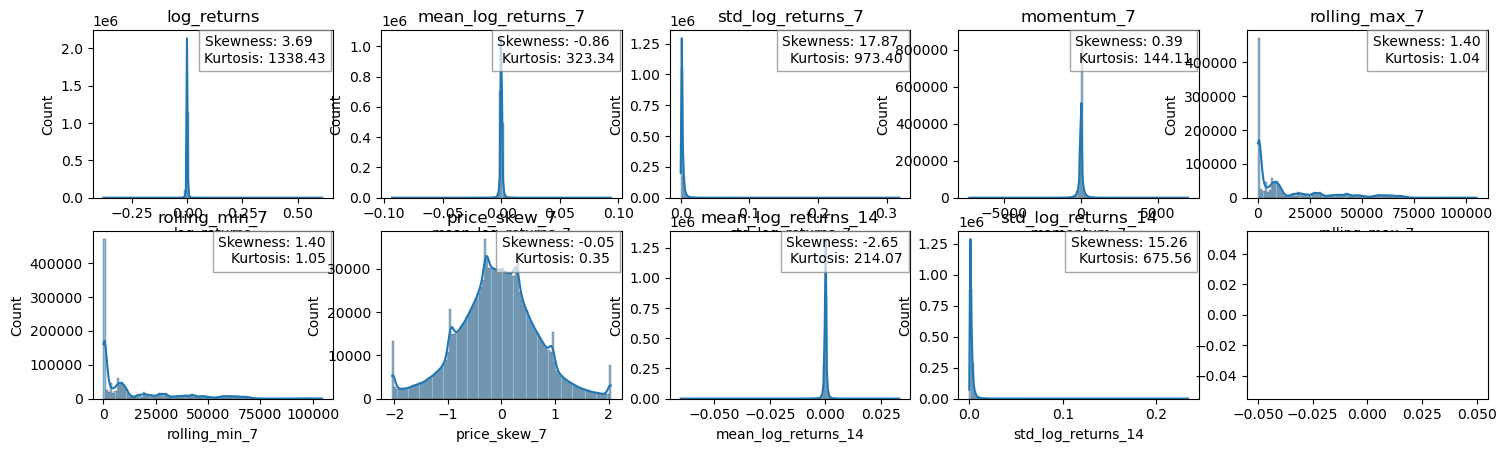

In [14]:
def plot_polar_distributions(df, cols_per_grid=20):    
    for i in range(1, len(df.columns), cols_per_grid):
        subset = df.columns[i:i+cols_per_grid]
        
        plt.figure(figsize=(18, 10)) 
        for j, col in enumerate(subset):
            ax = plt.subplot(4, 5, j+1)
            
            data = df.select(col)
            sns.histplot(data, kde=True, bins=100, ax=ax, legend=False)

            skewness = skew(data.to_series())
            kurt = kurtosis(data.to_series())

            skew_str = f"Skewness: {skewness:.2f}"
            kurt_str = f"Kurtosis: {kurt:.2f}"

            max_length = max(len(skew_str), len(kurt_str))
            skew_str = skew_str.ljust(max_length)
            kurt_str = kurt_str.ljust(max_length)
            textstr = f"{skew_str}\n{kurt_str}"

            ax.text(0.97, 0.97, textstr, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
            
            plt.xlabel(col)
            plt.title(f'{col}')
        
        plt.tight_layout()
        plt.show()

plot_polar_distributions(features)

In [26]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformer = PowerTransformer(method='yeo-johnson')
        self._transform_kind = None  # store how we want to output?

    def set_output(self, transform=None):
        """
        Called by scikit-learn when .set_output(transform=...) is used.
        We can choose to store this setting and produce DataFrame output
        in transform() if transform='pandas'.
        """
        self._transform_kind = transform  # e.g. 'pandas' or 'default'
        return self

    def fit(self, X, y=None):
        self.transformer.fit(X)
        return self

    def transform(self, X):
        transformed = self.transformer.transform(X)
        if self._transform_kind == 'pandas':
            # convert to DataFrame with some column names:
            # you'd need to decide what those names are
            if hasattr(X, "columns"):
                return pd.DataFrame(transformed, columns=X.columns, index=X.index)
            else:
                return pd.DataFrame(transformed)
        else:
            # default to returning a NumPy array
            return transformed
        
    def get_feature_names_out(self):
        pass
    

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=[0.01, 0.01]):
        self.limits = limits
        self._transform_kind = None  # Will be set by set_output()

    def set_output(self, transform=None):
        """
        This method is called internally by scikit-learn when you do:
            your_pipeline.set_output(transform="pandas")
        or
            your_column_transformer.set_output(transform="pandas")
        If transform='pandas', we will return a DataFrame in transform().
        """
        self._transform_kind = transform
        return self

    def fit(self, X, y=None):
        # Winsorizer does not need to learn any parameters from X
        return self

    def transform(self, X):
        """
        If self._transform_kind == 'pandas' and X has column names,
        we return a pandas DataFrame with the same columns/index.
        Otherwise, we return a NumPy array (the default scikit-learn behavior).
        """
        # Check if X is a DataFrame to preserve column names
        if hasattr(X, "columns"):
            X_values = X.values
            col_names = X.columns
            idx = X.index
        else:
            X_values = X
            col_names = None
            idx = None

        # Apply winsorize along each column
        winsorized = np.apply_along_axis(
            lambda col: mstats.winsorize(col, limits=self.limits),
            axis=0,
            arr=X_values
        )

        # If we want DataFrame output
        if self._transform_kind == "pandas":
            # Rebuild as a DataFrame if we have original column names
            if col_names is not None:
                return pd.DataFrame(winsorized, columns=col_names, index=idx)
            else:
                return pd.DataFrame(winsorized)
        else:
            # Return NumPy array (default behavior)
            return winsorized
        
    def get_feature_names_out(self):
        pass
        

from sklearn.preprocessing import FunctionTransformer

def yj_transform_func(X):
    return PowerTransformer(method='yeo-johnson').fit_transform(X)

yj_transformer = FunctionTransformer(yj_transform_func, feature_names_out="one-to-one")

class DataProcessor:
    def __init__(self, 
                 include_scaling=None,
                 skew_threshold=2, 
                 kurtosis_threshold=10, 
                 winsor_limits=[0.01, 0.01]):
        self.include_scaling = include_scaling or []
        self.skew_threshold = skew_threshold
        self.kurtosis_threshold = kurtosis_threshold
        self.winsor_limits = winsor_limits
        
        self.preprocessing_pipeline = None
        self.final_pipeline = None

    def _categorize_features(self, X):
        categories = {
            'yeo_johnson_only': [],
            'winsorizing_only': [],
            'yeo_johnson_winsorizing': [],
            'none': []
        }

        for col in X.columns:
            col_skewness = skew(X[col])
            col_kurtosis = kurtosis(X[col], fisher=False)
            
            if col_skewness > self.skew_threshold and col_kurtosis > self.kurtosis_threshold:
                categories['yeo_johnson_winsorizing'].append(col)
            elif col_skewness > self.skew_threshold:
                categories['yeo_johnson_only'].append(col)
            elif col_kurtosis > self.kurtosis_threshold:
                categories['winsorizing_only'].append(col)
            else:
                categories['none'].append(col)
                
        return categories

    def _build_pipeline(self, columns, categories):
        preprocessing_pipeline = ColumnTransformer(
            transformers=[
                ('yeo_johnson_only', YeoJohnsonTransformer(), 
                categories['yeo_johnson_only']),
        
                ('winsorizing_only', Winsorizer(limits=self.winsor_limits),
                categories['winsorizing_only']),
                
                ('yeo_johnson_winsorizing', Pipeline([
                    ('yeo_johnson', YeoJohnsonTransformer()),
                    ('winsor', Winsorizer(limits=self.winsor_limits))
                ]), categories['yeo_johnson_winsorizing']),

                ('none', 'passthrough', categories['none'])
            ], 
            n_jobs=-1
        )
        preprocessing_pipeline.set_output(transform="pandas")
        
        include_scaling = [i for i, col in enumerate(columns) if col in self.include_scaling]
        
        scaling_transformer = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), include_scaling)
            ],
            remainder='passthrough', verbose_feature_names_out=False
        )
        #scaling_transformer.set_output(transform="pandas")
        
        final_pipeline = Pipeline([
            ('preprocessing', preprocessing_pipeline),
            ('scaling', scaling_transformer)
        ])

        #final_pipeline.set_output(transform="pandas")

        return final_pipeline

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        columns = X_df.columns
        categories = self._categorize_features(X_df)
        self.final_pipeline = self._build_pipeline(columns, categories)
        self.final_pipeline.fit(X_df, y)
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        return pd.DataFrame(self.final_pipeline.transform(X_df), index=X_df.index, columns=X_df.columns)
        #return self.final_pipeline.transform(X_df) 

    def fit_transform(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        self.fit(X_df, y)
        return pd.DataFrame(self.final_pipeline.transform(X_df), index=X_df.index, columns=X_df.columns)

In [ ]:
features_pd = features.to_pandas().set_index("Date")
include_scaling = features_pd.loc[:, :"hour_sin"].columns.tolist()[:-1]
features_trans = DataProcessor(include_scaling=include_scaling)
data = features_trans.fit(features_pd).transform(features_pd)
data

/Users/anthony/miniforge3/envs/momentum_trading/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,log_returns,mean_log_returns_7,std_log_returns_7,momentum_7,rolling_max_7,rolling_min_7,price_skew_7,mean_log_returns_14,std_log_returns_14,momentum_14,...,mean_volume_30,std_volume_30,hour_sin,hour_cos,day_sin,day_cos,us_session,asia_session,eu_session,weekend
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01 20:25:00,3.594460,-0.003611,3.550295,-0.006375,3.519149,-0.007652,3.484121,-0.009173,-0.012442,-0.013210,...,-1.058130,1.845224,-0.806445,0.591310,0.691513,0.722364,0.0,0.0,0.0,1.0
2012-01-01 20:30:00,3.594460,-0.003611,3.550295,-0.006375,3.519149,-0.007652,3.484121,-0.009173,-0.012078,-0.013054,...,-1.058130,1.845224,-0.793353,0.608761,0.693761,0.720205,0.0,0.0,0.0,1.0
2012-01-01 20:35:00,3.594460,-0.003611,3.550295,-0.006375,3.519149,-0.007652,3.484121,-0.009173,-0.011802,-0.012871,...,-1.058130,1.845224,-0.779884,0.625923,0.696002,0.718040,0.0,0.0,0.0,1.0
2012-01-01 20:40:00,3.594460,-0.003611,3.550295,-0.006375,3.519149,-0.007652,3.484121,-0.009173,-0.011599,-0.012681,...,-1.058130,1.845224,-0.766044,0.642788,0.698237,0.715867,0.0,0.0,0.0,1.0
2012-01-01 20:45:00,3.594460,-0.003611,3.550295,-0.006375,3.519149,-0.007652,3.484121,-0.009173,-0.011454,-0.012499,...,-1.058130,1.845224,-0.751840,0.659346,0.700465,0.713687,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-15 23:40:00,1.808037,4.205217,1.636935,4.184640,2.058001,4.201328,1.376012,4.211467,4.218231,4.221969,...,1.973824,-0.899678,-0.087156,0.996195,0.773998,0.633188,0.0,0.0,0.0,1.0
2024-12-15 23:45:00,1.793915,4.205217,1.805138,4.184640,1.961941,4.201328,1.545380,4.211467,4.218231,4.221969,...,1.973830,-0.899635,-0.065403,0.997859,0.775968,0.630773,0.0,0.0,0.0,1.0
2024-12-15 23:50:00,0.925467,4.205217,1.566173,4.184640,1.685513,4.201328,1.420106,4.211467,4.218231,4.221969,...,1.973834,-0.899671,-0.043619,0.999048,0.777930,0.628351,0.0,0.0,0.0,1.0


### **Long Short Term Memory (LSTM)**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.base import BaseEstimator, RegressorMixin

class LSTMModel(nn.Module):
    def __init__(self, n_units=50, input_size=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, n_units, batch_first=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        self.fc = nn.Linear(n_units, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, timesteps, n_units)
        out = out[:, -1, :]    # Take the last timestep's output
        if self.dropout:
            out = self.dropout(out)
        out = self.fc(out)     # (batch, 1)
        return out

class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 learning_rate=0.01,
                 n_units=50,
                 dropout=0.0,
                 loss='mse',
                 epochs=10,
                 batch_size=32,
                 verbose=0,
                 patience=3,
                 seq_len=10,
                 n_workers=0,
                 device=None):
        self.learning_rate = learning_rate
        self.n_units = n_units
        self.dropout = dropout
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.patience = patience
        self.seq_len = seq_len
        self.n_workers = n_workers
        self.is_sequence_model = True

        if device is None:
            if torch.backends.mps.is_available():
                self.device = torch.device("mps")
            elif torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)

        self.model_ = None

    def _get_loss_function(self):
        if self.loss == 'mse':
            return nn.MSELoss()
        elif self.loss == 'mae':
            return nn.L1Loss()
        else:
            raise ValueError(f"Unsupported loss: {self.loss}")

    def _create_sequences(self, X, y=None):
        N, _ = X.shape
        if N <= self.seq_len:
            raise ValueError("Number of observations must be greater than seq_len.")

        X_seq = []
        if y is not None:
            y_seq = []

        for i in range(N - self.seq_len):
            X_seq.append(X[i:i+self.seq_len, :])
            if y is not None:
                y_seq.append(y[i+self.seq_len])

        X_seq = np.array(X_seq, dtype=np.float32)
        if y is not None:
            y_seq = np.array(y_seq, dtype=np.float32)
            return X_seq, y_seq
        return X_seq

    def build_model(self, input_size):
        model = LSTMModel(n_units=self.n_units, input_size=input_size, dropout=self.dropout)
        return model.to(self.device)

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.values.ravel()  # ensure 1D array

        X_train_seq, y_train_seq = self._create_sequences(X_train, y_train)

        # Create tensors directly on the target device
        X_train_t = torch.tensor(X_train_seq, dtype=torch.float32, device=self.device)
        y_train_t = torch.tensor(y_train_seq, dtype=torch.float32, device=self.device).unsqueeze(-1)

        _, _, input_size = X_train_seq.shape

        if self.model_ is None:
            self.model_ = self.build_model(input_size)

        dataset = TensorDataset(X_train_t, y_train_t)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, num_workers=self.n_workers)

        optimizer = Adam(self.model_.parameters(), lr=self.learning_rate)
        criterion = self._get_loss_function()

        best_loss = np.inf
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model_.train()
            epoch_loss = 0.0
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                preds = self.model_(X_batch)
                loss_val = criterion(preds, y_batch)
                loss_val.backward()
                optimizer.step()
                epoch_loss += loss_val.item() * X_batch.size(0)

            epoch_loss /= len(dataset)
            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print("Early stopping triggered.")
                    break

        return self

    def predict(self, X_test):
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values

        X_test_seq = self._create_sequences(X_test)

        self.model_.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_seq, dtype=torch.float32, device=self.device)
            preds = self.model_(X_test_t)
            return preds.cpu().numpy().ravel()

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        # If model parameters changed in a way that requires rebuilding the model:
        self.model_ = None
        return self

    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'n_units': self.n_units,
            'dropout': self.dropout,
            'loss': self.loss,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose,
            'patience': self.patience,
            'seq_len': self.seq_len,
            'device': self.device.type if isinstance(self.device, torch.device) else self.device
        }


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = ['wind_boxcox', 'load']

X_train[scaled_features] = scaler.fit_transform(X_train[scaled_features])

X_val = val[X_train.columns]
y_val = val[target]
X_test = test[X_train.columns]
y_test = test[target]

X_val[scaled_features] = scaler.transform(X_val[scaled_features])
X_test[scaled_features] = scaler.transform(X_test[scaled_features])
lstm_params = {
    "learning_rate": [0.005, 0.01, 0.05],
    "n_units": [32, 50, 100],
    "dropout": [0.0, 0.1, 0.2]
}

lstm_model = LSTMRegressor(device="cpu", batch_size=64, seq_len=21, learning_rate=0.05)

lstm_best_params = hyperparameter_tuning(
    lstm_model,
    lstm_params,
    X_train,
    y_train,
    X_val,
    y_val,
    imbalances_val,
    val["spread"]
)

results_lstm = evaluate_model(
    lstm_model, lstm_best_params[0], 
    X_train, y_train, X_val, y_val, X_test, y_test, 
    imbalances_test, test["spread"]
)

print(f"Cumulated PnL: {results_lstm['pnl_cumsum'].iloc[-1]:,.2f}€")
results_lstm['pnl_cumsum'].plot(figsize=(12, 6))